In [1]:

import os
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from plm_subnetworks.dataset import data_io
from plm_subnetworks.dataset.cath_dataset import get_cath_db
from plm_subnetworks.dataset.data_paths import ESMFOLD_650M_PDBS, ESM_TMALIGN_METRICS
from plm_subnetworks.dataset.constants import DSSP_3


RUN_DIR_PREFIX = "../results/subnetworks"  # Change this to runs/ if evaluating new trained subnetworks

parser = PDBParser(QUIET=True)
db = get_cath_db()

In [2]:
def compute_bfactors_split(pdb_path, dssp, DSSP_CODE):
    try:
        structure = parser.get_structure("protein", pdb_path)
        residue_b_factors = []

        for model in structure:
            for chain in model:
                for residue in chain:
                    b_factors = [atom.get_bfactor() for atom in residue if atom.get_bfactor() is not None]
                    if b_factors:
                        residue_b_factors.append(np.mean(b_factors))

        # Truncate DSSP if longer than B-factor list
        min_len = min(len(dssp), len(residue_b_factors))
        dssp_filtered = dssp[:min_len]
        residue_b_factors = np.array(residue_b_factors[:min_len])

        mask = np.array([c == DSSP_CODE for c in dssp_filtered])

        return (
            residue_b_factors[mask].mean() if mask.any() else np.nan,
            residue_b_factors[~mask].mean() if (~mask).any() else np.nan
        )

    except Exception as e:
        print(f"Error processing {pdb_path}: {e}")
        return np.nan, np.nan



In [3]:
def load_and_process(run_dir: str, DSSP_CODE: str):
    run_path = f"{RUN_DIR_PREFIX}/{run_dir}"
    folded_dir = f"{run_path}/folded"
    sub_pdb_dir = f"{folded_dir}/pred"

    print(f"Sub PDB dir: {sub_pdb_dir}")

    # Load precomputed TMalign scores
    esm_df = pd.read_csv(ESM_TMALIGN_METRICS)
    sub_df = pd.read_csv(f"{run_path}/tmalign.csv")

    esm_df = data_io.hydrate_df_with_cath_terms(esm_df, db)
    sub_df = data_io.hydrate_df_with_cath_terms(sub_df, db)

    esm_supp, esm_maint, sub_supp, sub_maint = [], [], [], []

    for _, row in tqdm(sub_df.iterrows(), total=len(sub_df)):
        cath_id = row["cath_id"]
        try:
            dssp = db.query(cath_id).dssp
            dssp = "".join([DSSP_3.get(res, "L") for res in dssp])

            esm_pdb_path = f"{ESMFOLD_650M_PDBS}/{cath_id}.pdb"
            sub_pdb_path = f"{sub_pdb_dir}/{cath_id}.pdb"

            if not os.path.exists(esm_pdb_path) or not os.path.exists(sub_pdb_path):
                print(f"Missing files for {cath_id}: {esm_pdb_path}, {sub_pdb_path}")
                continue

            esm_s, esm_m = compute_bfactors_split(esm_pdb_path, dssp, DSSP_CODE)
            sub_s, sub_m = compute_bfactors_split(sub_pdb_path, dssp, DSSP_CODE)

            if not np.isnan(esm_s): esm_supp.append(esm_s)
            if not np.isnan(esm_m): esm_maint.append(esm_m)
            if not np.isnan(sub_s): sub_supp.append(sub_s)
            if not np.isnan(sub_m): sub_maint.append(sub_m)

        except Exception as e:
            print(f"Failed for {cath_id}: {e}")
            continue

    return esm_supp, esm_maint, sub_supp, sub_maint


#### Plot Figures 3 F (alpha-type suppression) and 3 G (beta type suppression)

In [4]:
# Toggle these blocks to switch between alpha and beta suppression

# # Alpha suppression
# proj_seq = "class_1"
# proj_res = "residue_1"
# DSSP_CODE = "H"
# TYPE="Alpha Helix"

# Beta suppression
proj_seq = "class_2"
proj_res = "residue_2"
DSSP_CODE = "E"
TYPE="Beta Sheet"

esm_res_supp, esm_res_maint, sub_res_supp, sub_res_maint = load_and_process(proj_res, DSSP_CODE)
esm_seq_supp, esm_seq_maint, sub_seq_supp, sub_seq_maint = load_and_process(proj_seq,  DSSP_CODE)



Sub PDB dir: ../results/subnetworks/residue_2/folded/pred


100%|██████████| 1777/1777 [01:21<00:00, 21.79it/s]


Sub PDB dir: ../results/subnetworks/class_2/folded/pred


100%|██████████| 1777/1777 [01:20<00:00, 22.04it/s]


In [5]:
# Combine everything
all_bfactors = pd.concat([
    pd.Series(sub_res_supp), pd.Series(esm_res_supp),
    pd.Series(sub_seq_supp), pd.Series(esm_seq_supp),
    pd.Series(sub_res_maint), pd.Series(esm_res_maint),
    pd.Series(sub_seq_maint), pd.Series(esm_seq_maint)
], ignore_index=True)

all_labels = (
    ["SuppressResidue-Sub"] * len(sub_res_supp) +
    ["SuppressResidue-ESM"] * len(esm_res_supp) +
    ["SuppressSeq-Sub"] * len(sub_seq_supp) +
    ["SuppressSeq-ESM"] * len(esm_seq_supp) +
    ["MaintainResidue-Sub"] * len(sub_res_maint) +
    ["MaintainResidue-ESM"] * len(esm_res_maint) +
    ["MaintainSeq-Sub"] * len(sub_seq_maint) +
    ["MaintainSeq-ESM"] * len(esm_seq_maint)
)

plot_data = pd.DataFrame({
    "B-factor": all_bfactors,
    "Condition": all_labels
})

condition_rename = {
    "SuppressResidue-Sub": "Suppress Residues (Sub)",
    "SuppressResidue-ESM": "Suppress Residues (ESM)",
    "SuppressSeq-Sub": "Suppress Sequences (Sub)",
    "SuppressSeq-ESM": "Suppress Sequences (ESM)",
    "MaintainResidue-Sub": "Maintain Residues (Sub)",
    "MaintainResidue-ESM": "Maintain Residues (ESM)",
    "MaintainSeq-Sub": "Maintain Sequences (Sub)",
    "MaintainSeq-ESM": "Maintain Sequences (ESM)",
}
plot_data["Condition"] = plot_data["Condition"].map(condition_rename)


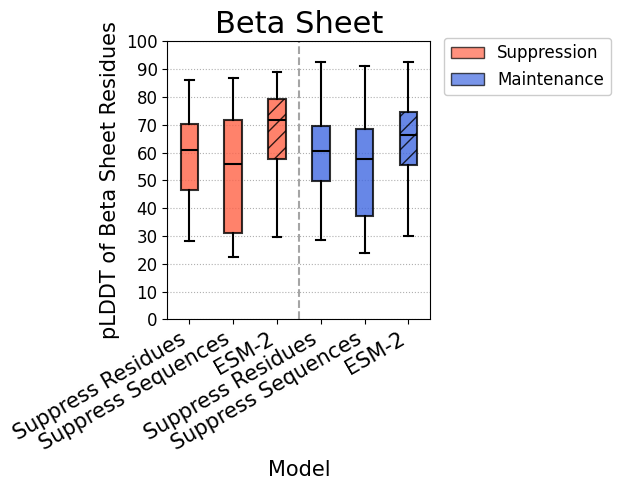

In [6]:

ordered_conditions = {
    "Suppress Residues (Sub)": "Suppress Residues",
    "Suppress Sequences (Sub)": "Suppress Sequences",
    "Suppress Residues (ESM)": "ESM-2",
    "Maintain Residues (Sub)": "Suppress Residues",
    "Maintain Sequences (Sub)": "Suppress Sequences",
    "Maintain Residues (ESM)": "ESM-2",
}
condition_keys = list(ordered_conditions.keys())

colors = ['tomato' if 'Suppress' in key else 'royalblue' for key in condition_keys]
hatches = ['//' if 'ESM' in key else '' for key in condition_keys]

grouped_data = [plot_data[plot_data['Condition'] == cond]['B-factor'].values for cond in condition_keys]

fig, ax = plt.subplots(figsize=(5, 5), dpi=100, facecolor='none')
ax.set_facecolor("none")

boxplot = ax.boxplot(
    grouped_data,
    patch_artist=True,
    positions=range(len(condition_keys)),
    widths=0.4,
    showfliers=False,
    medianprops=dict(color='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    boxprops=dict(color='black', linewidth=1.5),
)

for i, box in enumerate(boxplot['boxes']):
    box.set_facecolor(colors[i])
    box.set_hatch(hatches[i])
    box.set_alpha(0.8)

ax.set_xticks(range(len(condition_keys)))
ax.set_xticklabels([ordered_conditions[key] for key in condition_keys], rotation=30, ha='right', fontsize=15)
ax.set_ylabel(f"pLDDT of {TYPE} Residues", fontsize=15)
ax.set_xlabel("Model", fontsize=15)
ax.set_title(f"{TYPE}", fontsize=22)

ax.axvline(x=2.5, linestyle='--', color='gray', alpha=0.7)
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, 10))
ax.tick_params(axis='y', labelsize=12)
ax.grid(True, axis='y', linestyle=':', linewidth=0.8)

legend_handles = [
    mpatches.Patch(facecolor='tomato', alpha=0.7, edgecolor='black', label='Suppression'),
    mpatches.Patch(facecolor='royalblue', alpha=0.7, edgecolor='black', label='Maintenance'),
]
ax.legend(
    handles=legend_handles,
    loc='center left',
    bbox_to_anchor=(1.02, 0.91),
    frameon=True,
    framealpha=1.0,
    fontsize=12
)

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()
